In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy


In [2]:
x_train = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import pickle
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [5]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train_fine, test_size=0.1, stratify=y_train_fine)

In [6]:
from matplotlib import pyplot as plt
%load_ext tensorboard

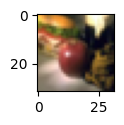

In [7]:
x_train_bis = x_train[:,:,::-1,:]
plt.figure(figsize=(1,1))
plt.imshow(x_train_bis[2])

In [8]:
print(y_train[2])

0


In [9]:
labels_fine[50]

'mouse'

In [10]:
x_train_dup = np.concatenate([x_train, x_train_bis],axis=0)
y_train_dup = np.concatenate([y_train, y_train], axis=0)
x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()
x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]
x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)


In [11]:
x_train_dup.shape, y_train_dup.shape

((270000, 32, 32, 3), (270000,))

In [12]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 10
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: large_natural_outdoor_scenes
Grano fino: cloud
Grano fino: forest
Grano fino: mountain
Grano fino: plain
Grano fino: sea


In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
#model.add(Dense(10000, activation="relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       307,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,300 (1.17 MB)

 Trainable params: 307,300 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [17]:
mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [18]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10, 
    verbose = 1,
    restore_best_weights = True,
)

In [19]:
tb = TensorBoard(
    log_dir="logs",
)

In [20]:
indexes = list(range(len(x_train_dup)))
np.random.shuffle(indexes)
x_train_dup = x_train_dup[indexes]
y_train_dup = y_train_dup[indexes]


In [21]:
history = model.fit(
    x = x_train, 
    y= y_train, 
    batch_size=32, 
    epochs=2, 
    validation_data = (x_val, y_val), 
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/2
1400/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0674 - loss: 4.6742
Epoch 1: val_accuracy improved from -inf to 0.11260, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.0675 - loss: 4.6731 - val_accuracy: 0.1126 - val_loss: 4.3408 - learning_rate: 0.0010
Epoch 2/2
1398/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1243 - loss: 4.2123
Epoch 2: val_accuracy improved from 0.11260 to 0.11860, saving model to best_weights.weights.h5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1243 - loss: 4.2123 - val_accuracy: 0.1186 - val_loss: 4.2592 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [22]:
!mkdir logs

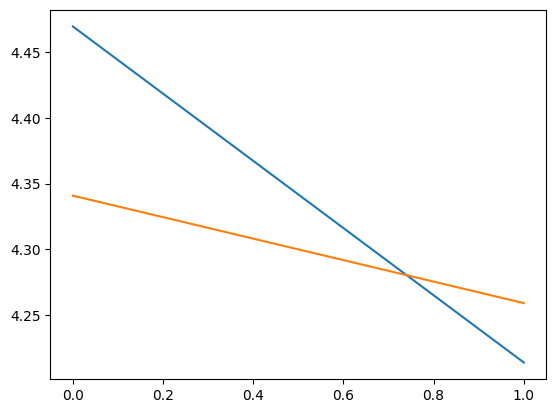

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

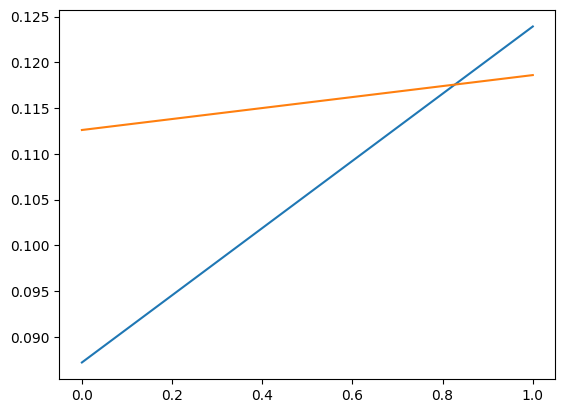

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

In [25]:
%tensorboard --logdir logs

In [26]:
predictions = model.predict(x_test).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
df = pd.DataFrame(predictions, columns=["Label"])

In [28]:
df

,Label
0,11
1,63
2,57
3,41
4,11
...,...
9995,3
9996,63
9997,18
9998,63


In [29]:
df.index.name = "Id"

In [30]:
df.to_csv("submission.csv")